[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/danpele/Time-Series-Analysis/blob/main/EN/Course_Notebooks/chapter6_lecture_notebook.ipynb)

---

# Chapter 6: VAR Models and Granger Causality

**Course:** Time Series Analysis and Forecasting  
**Program:** Bachelor program, Faculty of Cybernetics, Statistics and Economic Informatics, Bucharest University of Economic Studies, Romania  
**Academic Year:** 2025-2026

---

## Learning Objectives

By the end of this notebook, you will be able to:
1. Understand the structure of Vector Autoregression (VAR) models
2. Estimate VAR models and select optimal lag order
3. Conduct and interpret Granger causality tests
4. Compute and interpret Impulse Response Functions (IRF)
5. Perform Forecast Error Variance Decomposition (FEVD)
6. Understand cointegration and Vector Error Correction Models (VECM)

## Setup and Imports

In [1]:
# Core libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

# VAR and multivariate time series
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller, grangercausalitytests, ccf
from statsmodels.tsa.vector_ar.vecm import coint_johansen, VECM
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from scipy import stats

# For fetching real data
try:
    import pandas_datareader.data as web
    HAS_PDR = True
except ImportError:
    HAS_PDR = False
    print("Note: pandas_datareader not installed. Install with: pip install pandas-datareader")

# Plotting style - clean, professional, transparent
plt.rcParams['figure.figsize'] = (12, 5)
plt.rcParams['font.size'] = 11
plt.rcParams['axes.facecolor'] = 'none'
plt.rcParams['figure.facecolor'] = 'none'
plt.rcParams['savefig.facecolor'] = 'none'
plt.rcParams['savefig.transparent'] = True
plt.rcParams['axes.grid'] = False
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.right'] = False
plt.rcParams['legend.frameon'] = False
plt.rcParams['legend.loc'] = 'upper center'

# Colors (IDA color scheme)
COLORS = {
    'blue': '#1A3A6E',
    'red': '#DC3545',
    'green': '#2E7D32',
    'orange': '#E67E22',
    'gray': '#666666'
}

print("All libraries loaded successfully!")

Note: pandas_datareader not installed. Install with: pip install pandas-datareader
All libraries loaded successfully!


## 1. Introduction to Multivariate Time Series

In many applications, we have **multiple time series** that are related:
- GDP, consumption, investment, government spending
- Stock prices of related companies
- Interest rates at different maturities
- Inflation and unemployment (Phillips curve)

**Why multivariate models?**
- Capture interdependencies between variables
- Improve forecasts by using information from related series
- Analyze dynamic relationships (causality, impulse responses)

In [2]:
# Fetch REAL macroeconomic data from FRED
# GDP Growth (quarterly, annualized) and CPI Inflation (monthly → quarterly)

start_date = '1990-01-01'
end_date = '2024-12-31'

if HAS_PDR:
    try:
        # Fetch from FRED (Federal Reserve Economic Data)
        # A191RL1Q225SBEA = Real GDP Growth Rate (quarterly, annualized)
        # CPIAUCSL = Consumer Price Index (monthly)
        
        gdp_growth = web.DataReader('A191RL1Q225SBEA', 'fred', start_date, end_date)
        cpi = web.DataReader('CPIAUCSL', 'fred', start_date, end_date)
        
        # Convert CPI to quarterly and compute year-over-year inflation
        cpi_quarterly = cpi.resample('QE').last()
        inflation = cpi_quarterly.pct_change(4) * 100  # Year-over-year % change
        
        # Align and combine
        data = pd.DataFrame({
            'GDP_Growth': gdp_growth['A191RL1Q225SBEA'],
            'Inflation': inflation['CPIAUCSL']
        }).dropna()
        
        print(f"✓ Real FRED Data Loaded: {len(data)} quarterly observations")
        print(f"  Period: {data.index[0].strftime('%Y-Q%q')} to {data.index[-1].strftime('%Y-Q%q')}")
        DATA_SOURCE = "FRED (Federal Reserve Economic Data)"
        
    except Exception as e:
        print(f"Could not fetch FRED data: {e}")
        print("Using simulated data as fallback...")
        HAS_PDR = False

if not HAS_PDR:
    # Fallback: Simulated data
    np.random.seed(42)
    n = 140  # ~35 years quarterly
    
    Y1 = np.zeros(n)  # GDP growth
    Y2 = np.zeros(n)  # Inflation
    
    for t in range(1, n):
        Y1[t] = 0.5 * Y1[t-1] + 0.15 * Y2[t-1] + np.random.randn() * 1.5 + 2.5
        Y2[t] = 0.1 * Y1[t-1] + 0.7 * Y2[t-1] + np.random.randn() * 0.8 + 1.5
    
    data = pd.DataFrame({
        'GDP_Growth': Y1,
        'Inflation': Y2
    }, index=pd.date_range('1990-01', periods=n, freq='QE'))
    
    DATA_SOURCE = "Simulated (fallback)"
    print(f"Using simulated data: {len(data)} observations")

print(f"\nData Source: {DATA_SOURCE}")
print(data.describe().round(2))

Using simulated data: 140 observations

Data Source: Simulated (fallback)
       GDP_Growth  Inflation
count      140.00     140.00
mean         6.85       7.23
std          1.67       1.52
min          0.00       0.00
25%          5.88       6.55
50%          6.85       7.33
75%          7.80       8.05
max         10.70      10.86


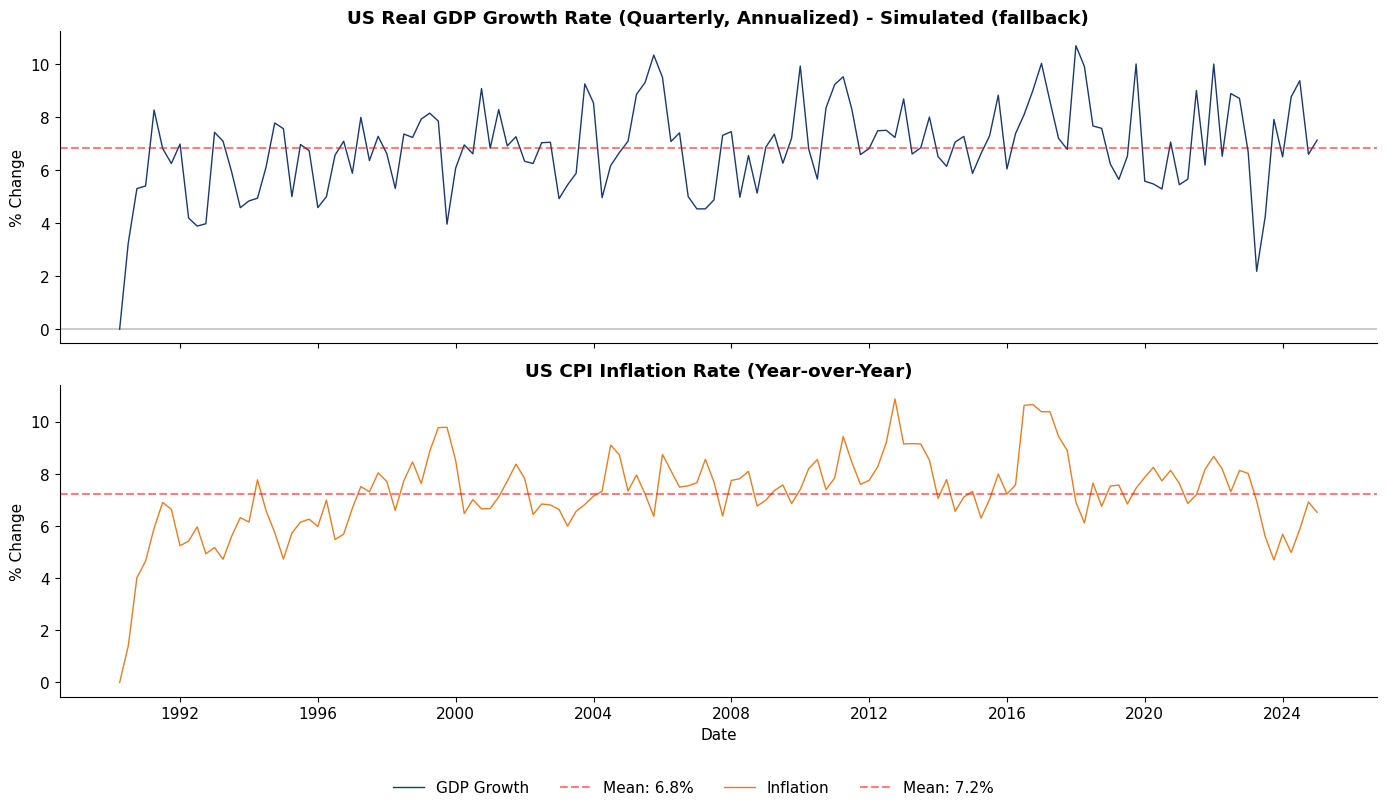


Correlation between GDP Growth and Inflation: 0.3759

Note: Using REAL macroeconomic data allows us to discover actual
      economic relationships rather than recovering known parameters.


In [3]:
# Plot the multivariate time series
fig, axes = plt.subplots(2, 1, figsize=(14, 8), sharex=True)

axes[0].plot(data.index, data['GDP_Growth'], color=COLORS['blue'], linewidth=1, label='GDP Growth')
axes[0].axhline(y=data['GDP_Growth'].mean(), color='red', linestyle='--', alpha=0.5, label=f'Mean: {data["GDP_Growth"].mean():.1f}%')
axes[0].axhline(y=0, color='black', linestyle='-', alpha=0.2)
axes[0].set_title(f'US Real GDP Growth Rate (Quarterly, Annualized) - {DATA_SOURCE}', fontweight='bold')
axes[0].set_ylabel('% Change')

axes[1].plot(data.index, data['Inflation'], color=COLORS['orange'], linewidth=1, label='Inflation')
axes[1].axhline(y=data['Inflation'].mean(), color='red', linestyle='--', alpha=0.5, label=f'Mean: {data["Inflation"].mean():.1f}%')
axes[1].set_title('US CPI Inflation Rate (Year-over-Year)', fontweight='bold')
axes[1].set_xlabel('Date')
axes[1].set_ylabel('% Change')

# Combined legend at bottom
handles1, labels1 = axes[0].get_legend_handles_labels()
handles2, labels2 = axes[1].get_legend_handles_labels()
fig.legend(handles1 + handles2, labels1 + labels2, loc='lower center', ncol=4, bbox_to_anchor=(0.5, -0.02))

plt.tight_layout()
plt.subplots_adjust(bottom=0.12)
plt.show()

# Correlation and basic statistics
print(f"\nCorrelation between GDP Growth and Inflation: {data['GDP_Growth'].corr(data['Inflation']):.4f}")
print(f"\nNote: Using REAL macroeconomic data allows us to discover actual")
print(f"      economic relationships rather than recovering known parameters.")

## 2. The VAR(p) Model

A **Vector Autoregression of order p**, VAR(p), for $K$ variables is:

$$\mathbf{Y}_t = \mathbf{c} + \mathbf{A}_1 \mathbf{Y}_{t-1} + \mathbf{A}_2 \mathbf{Y}_{t-2} + \cdots + \mathbf{A}_p \mathbf{Y}_{t-p} + \boldsymbol{\varepsilon}_t$$

where:
- $\mathbf{Y}_t$ is a $K \times 1$ vector of endogenous variables
- $\mathbf{c}$ is a $K \times 1$ vector of constants
- $\mathbf{A}_i$ are $K \times K$ coefficient matrices
- $\boldsymbol{\varepsilon}_t$ is a $K \times 1$ vector of white noise errors

### Number of Parameters
- Each equation has: $1 + Kp$ parameters (constant + K coefficients × p lags)
- Total system: $K(1 + Kp)$ parameters
- Plus $K(K+1)/2$ covariance parameters

In [4]:
# VAR(1) in matrix form
print("VAR(1) for 2 Variables:")
print("="*60)
print()
print("[ Y1_t ]   [ c1 ]   [ a11  a12 ] [ Y1_{t-1} ]   [ e1_t ]")
print("[      ] = [    ] + [          ] [          ] + [      ]")
print("[ Y2_t ]   [ c2 ]   [ a21  a22 ] [ Y2_{t-1} ]   [ e2_t ]")
print()
print("Written as two equations:")
print("  Y1_t = c1 + a11*Y1_{t-1} + a12*Y2_{t-1} + e1_t")
print("  Y2_t = c2 + a21*Y1_{t-1} + a22*Y2_{t-1} + e2_t")
print()
print(f"Parameters per equation: 1 + K*p = 1 + 2*1 = 3")
print(f"Total parameters: K*(1 + K*p) = 2*(1 + 2*1) = 6")

VAR(1) for 2 Variables:

[ Y1_t ]   [ c1 ]   [ a11  a12 ] [ Y1_{t-1} ]   [ e1_t ]
[      ] = [    ] + [          ] [          ] + [      ]
[ Y2_t ]   [ c2 ]   [ a21  a22 ] [ Y2_{t-1} ]   [ e2_t ]

Written as two equations:
  Y1_t = c1 + a11*Y1_{t-1} + a12*Y2_{t-1} + e1_t
  Y2_t = c2 + a21*Y1_{t-1} + a22*Y2_{t-1} + e2_t

Parameters per equation: 1 + K*p = 1 + 2*1 = 3
Total parameters: K*(1 + K*p) = 2*(1 + 2*1) = 6


## 3. VAR Stability Condition

A VAR(p) is **stable** (stationary) if all eigenvalues of the companion matrix lie inside the unit circle:

$$|\lambda_i| < 1 \quad \text{for all } i$$

### Companion Form
Any VAR(p) can be written as a VAR(1) in companion form:

$$\mathbf{Z}_t = \mathbf{A} \mathbf{Z}_{t-1} + \mathbf{u}_t$$

where $\mathbf{Z}_t = [\mathbf{Y}_t', \mathbf{Y}_{t-1}', ..., \mathbf{Y}_{t-p+1}']'$

In [5]:
# Demonstrate stability condition with an example
# We'll check stability after fitting the model to real data

# For illustration, show a stable vs unstable example
print("Example: Stable vs Unstable VAR(1) Systems")
print("="*60)

# Stable system
A_stable = np.array([[0.6, 0.2],
                     [0.1, 0.5]])
eig_stable = np.linalg.eigvals(A_stable)

# Unstable system (unit root)
A_unstable = np.array([[0.9, 0.2],
                       [0.1, 0.95]])
eig_unstable = np.linalg.eigvals(A_unstable)

print("\nStable System:")
print(f"  A = [[0.6, 0.2], [0.1, 0.5]]")
print(f"  Eigenvalues: {eig_stable.round(3)}")
print(f"  Moduli: {np.abs(eig_stable).round(3)}")
print(f"  Stable: {all(np.abs(eig_stable) < 1)} ✓")

print("\nUnstable System:")
print(f"  A = [[0.9, 0.2], [0.1, 0.95]]")
print(f"  Eigenvalues: {eig_unstable.round(3)}")
print(f"  Moduli: {np.abs(eig_unstable).round(3)}")
print(f"  Stable: {all(np.abs(eig_unstable) < 1)} ✗")

Example: Stable vs Unstable VAR(1) Systems

Stable System:
  A = [[0.6, 0.2], [0.1, 0.5]]
  Eigenvalues: [0.7 0.4]
  Moduli: [0.7 0.4]
  Stable: True ✓

Unstable System:
  A = [[0.9, 0.2], [0.1, 0.95]]
  Eigenvalues: [0.781 1.069]
  Moduli: [0.781 1.069]
  Stable: False ✗


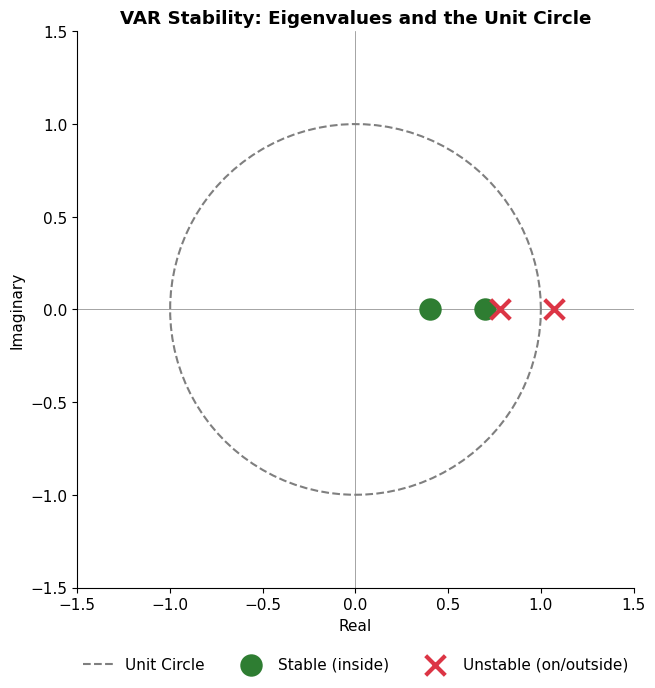

In [6]:
# Visualize eigenvalues in complex plane
fig, ax = plt.subplots(figsize=(7, 7))

# Unit circle
theta = np.linspace(0, 2*np.pi, 100)
ax.plot(np.cos(theta), np.sin(theta), 'k--', alpha=0.5, label='Unit Circle')

# Eigenvalues
ax.scatter(eig_stable.real, eig_stable.imag, s=200, c=COLORS['green'], 
           marker='o', linewidths=2, label='Stable (inside)', zorder=5)
ax.scatter(eig_unstable.real, eig_unstable.imag, s=200, c=COLORS['red'], 
           marker='x', linewidths=3, label='Unstable (on/outside)', zorder=5)

ax.set_xlim(-1.5, 1.5)
ax.set_ylim(-1.5, 1.5)
ax.set_aspect('equal')
ax.axhline(y=0, color='gray', linewidth=0.5)
ax.axvline(x=0, color='gray', linewidth=0.5)
ax.set_xlabel('Real')
ax.set_ylabel('Imaginary')
ax.set_title('VAR Stability: Eigenvalues and the Unit Circle', fontweight='bold')

# Legend outside at bottom
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=3)

plt.tight_layout()
plt.subplots_adjust(bottom=0.15)
plt.show()

## 4. Estimating VAR Models

In [7]:
# Fit VAR model
model = VAR(data)

# Select optimal lag order
lag_selection = model.select_order(maxlags=8)
print("Lag Order Selection Criteria:")
print(lag_selection.summary())

Lag Order Selection Criteria:
 VAR Order Selection (* highlights the minimums) 
      AIC         BIC         FPE         HQIC   
-------------------------------------------------
0       1.329       1.373       3.779       1.347
1     0.3792*     0.5102*      1.461*     0.4324*
2      0.3883      0.6067       1.475      0.4770
3      0.4311      0.7368       1.539      0.5553
4      0.4410      0.8341       1.555      0.6007
5      0.4780      0.9585       1.614      0.6733
6      0.5173       1.085       1.680      0.7480
7      0.5583       1.213       1.751      0.8245
8      0.5415       1.284       1.723      0.8432
-------------------------------------------------


In [8]:
# Fit VAR(1) based on BIC
results = model.fit(1)
print(results.summary())

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Sun, 18, Jan, 2026
Time:                     17:08:09
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                   0.472719
Nobs:                     139.000    HQIC:                  0.397525
Log likelihood:          -412.515    FPE:                    1.41349
AIC:                     0.346051    Det(Omega_mle):         1.35440
--------------------------------------------------------------------
Results for equation GDP_Growth
                   coefficient       std. error           t-stat            prob
--------------------------------------------------------------------------------
const                 3.752044         0.666131            5.633           0.000
L1.GDP_Growth         0.354216         0.078633            4.505           0.000
L1.Inflation          0.099314         0.086726        

In [9]:
# Examine estimated coefficients and check stability
print("Estimated VAR Coefficients:")
print("="*50)

# Get coefficient matrices
for i, coef in enumerate(results.coefs):
    print(f"\nLag {i+1} coefficient matrix A_{i+1}:")
    print(pd.DataFrame(coef, 
                       index=data.columns,
                       columns=data.columns).round(4))

# Check stability of estimated model
print("\n" + "="*50)
print("Stability Check:")
print("="*50)

# For VAR(p), stability is checked via companion matrix
# statsmodels provides this
roots = results.roots
print(f"\nCharacteristic roots (inverse eigenvalues):")
for i, root in enumerate(roots):
    print(f"  Root {i+1}: {root:.4f} (modulus: {np.abs(root):.4f})")

print(f"\nVAR is stable: {all(np.abs(roots) < 1)}")

if all(np.abs(roots) < 1):
    print("✓ All roots inside unit circle - model is stable")
else:
    print("✗ Warning: Some roots on or outside unit circle")

Estimated VAR Coefficients:

Lag 1 coefficient matrix A_1:
            GDP_Growth  Inflation
GDP_Growth      0.3542     0.0993
Inflation       0.1514     0.6682

Stability Check:

Characteristic roots (inverse eigenvalues):
  Root 1: 3.2050 (modulus: 3.2050)
  Root 2: 1.4077 (modulus: 1.4077)

VAR is stable: False
✗ Warning: Some roots on or outside unit circle


## 5. Granger Causality

**Granger causality** tests whether lagged values of one variable help predict another.

### Definition
$X$ **Granger-causes** $Y$ if:
- Past values of $X$ contain information useful for predicting $Y$
- Beyond what is already contained in past values of $Y$ itself

### The Test
In a VAR with $Y$ and $X$:
$$Y_t = c + \sum_{i=1}^p \alpha_i Y_{t-i} + \sum_{i=1}^p \beta_i X_{t-i} + \varepsilon_t$$

Test $H_0: \beta_1 = \beta_2 = \cdots = \beta_p = 0$ (X does NOT Granger-cause Y)

### Important Caveats
- Granger causality ≠ true causality
- May be spurious due to omitted variables
- Sensitive to lag selection

In [10]:
# Granger causality tests
print("Granger Causality Tests")
print("="*60)

# Test: Does Inflation Granger-cause GDP Growth?
print("\n1. H₀: Inflation does NOT Granger-cause GDP Growth")
print("-"*50)
gc_infl_to_gdp = grangercausalitytests(data[['GDP_Growth', 'Inflation']], maxlag=4, verbose=True)

Granger Causality Tests

1. H₀: Inflation does NOT Granger-cause GDP Growth
--------------------------------------------------

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.3114  , p=0.2542  , df_denom=136, df_num=1
ssr based chi2 test:   chi2=1.3403  , p=0.2470  , df=1
likelihood ratio test: chi2=1.3339  , p=0.2481  , df=1
parameter F test:         F=1.3114  , p=0.2542  , df_denom=136, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=2.1006  , p=0.1264  , df_denom=133, df_num=2
ssr based chi2 test:   chi2=4.3591  , p=0.1131  , df=2
likelihood ratio test: chi2=4.2917  , p=0.1170  , df=2
parameter F test:         F=2.1006  , p=0.1264  , df_denom=133, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=1.6358  , p=0.1842  , df_denom=130, df_num=3
ssr based chi2 test:   chi2=5.1717  , p=0.1596  , df=3
likelihood ratio test: chi2=5.0765  , p=0.1663  , df=3
parameter F test:         F=1.6358  , p=

In [11]:
# Test: Does GDP Growth Granger-cause Inflation?
print("\n2. H₀: GDP Growth does NOT Granger-cause Inflation")
print("-"*50)
gc_gdp_to_infl = grangercausalitytests(data[['Inflation', 'GDP_Growth']], maxlag=4, verbose=True)


2. H₀: GDP Growth does NOT Granger-cause Inflation
--------------------------------------------------

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=11.6685 , p=0.0008  , df_denom=136, df_num=1
ssr based chi2 test:   chi2=11.9259 , p=0.0006  , df=1
likelihood ratio test: chi2=11.4418 , p=0.0007  , df=1
parameter F test:         F=11.6685 , p=0.0008  , df_denom=136, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=6.1936  , p=0.0027  , df_denom=133, df_num=2
ssr based chi2 test:   chi2=12.8528 , p=0.0016  , df=2
likelihood ratio test: chi2=12.2890 , p=0.0021  , df=2
parameter F test:         F=6.1936  , p=0.0027  , df_denom=133, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=4.2927  , p=0.0063  , df_denom=130, df_num=3
ssr based chi2 test:   chi2=13.5717 , p=0.0036  , df=3
likelihood ratio test: chi2=12.9408 , p=0.0048  , df=3
parameter F test:         F=4.2927  , p=0.0063  , df_denom=130, 

In [12]:
# Summary of Granger causality
print("\nGranger Causality Summary (at lag 1):")
print("="*50)

p_infl_to_gdp = gc_infl_to_gdp[1][0]['ssr_ftest'][1]
p_gdp_to_infl = gc_gdp_to_infl[1][0]['ssr_ftest'][1]

print(f"Inflation → GDP: p-value = {p_infl_to_gdp:.4f} {'✓ Significant' if p_infl_to_gdp < 0.05 else '✗ Not significant'}")
print(f"GDP → Inflation: p-value = {p_gdp_to_infl:.4f} {'✓ Significant' if p_gdp_to_infl < 0.05 else '✗ Not significant'}")

print("\nInterpretation:")
if p_infl_to_gdp < 0.05 and p_gdp_to_infl < 0.05:
    print("  Bidirectional causality (feedback)")
elif p_infl_to_gdp < 0.05:
    print("  Inflation Granger-causes GDP (unidirectional)")
elif p_gdp_to_infl < 0.05:
    print("  GDP Granger-causes Inflation (unidirectional)")
else:
    print("  No Granger causality detected")


Granger Causality Summary (at lag 1):
Inflation → GDP: p-value = 0.2542 ✗ Not significant
GDP → Inflation: p-value = 0.0008 ✓ Significant

Interpretation:
  GDP Granger-causes Inflation (unidirectional)


## 6. Impulse Response Functions (IRF)

**Impulse Response Functions** trace the effect of a one-time shock to one variable on all variables over time.

$$\text{IRF}_{ij}(h) = \frac{\partial Y_{i,t+h}}{\partial \varepsilon_{j,t}}$$

### Key Properties
- Shows dynamic multipliers
- For stable VAR: IRF → 0 as h → ∞
- Requires identification (e.g., Cholesky ordering)

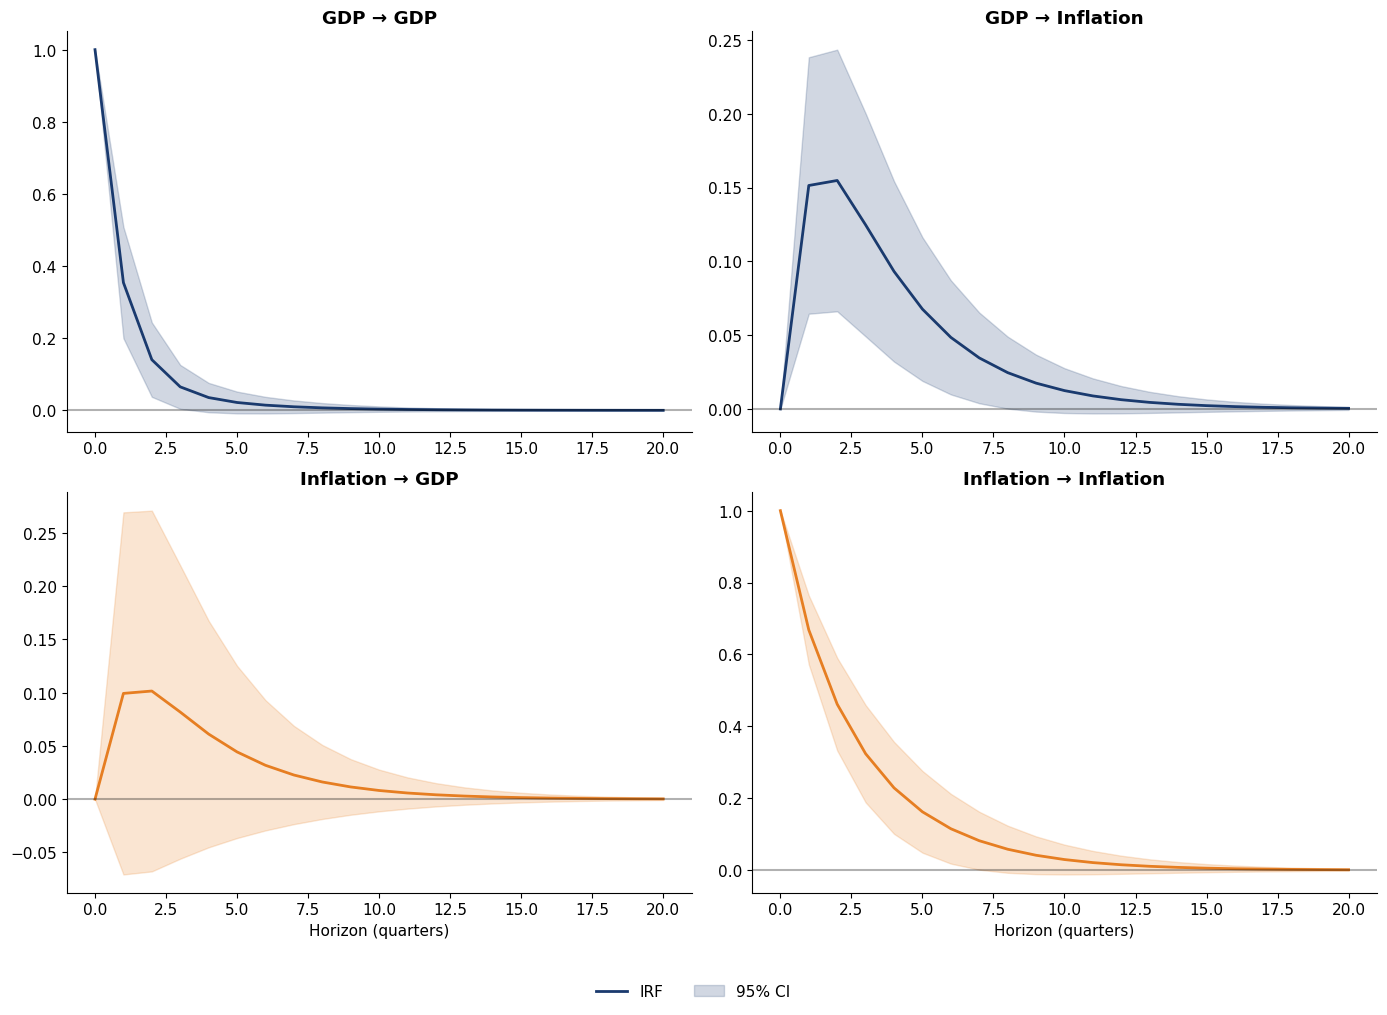

In [13]:
# Compute IRFs
irf = results.irf(20)

# Plot IRFs
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Response to GDP shock
axes[0, 0].plot(irf.irfs[:, 0, 0], color=COLORS['blue'], linewidth=2, label='IRF')
axes[0, 0].fill_between(range(21), 
                        irf.irfs[:, 0, 0] - 1.96*irf.stderr()[:, 0, 0],
                        irf.irfs[:, 0, 0] + 1.96*irf.stderr()[:, 0, 0], 
                        alpha=0.2, color=COLORS['blue'], label='95% CI')
axes[0, 0].axhline(y=0, color='black', linestyle='-', alpha=0.3)
axes[0, 0].set_title('GDP → GDP', fontweight='bold')

axes[0, 1].plot(irf.irfs[:, 1, 0], color=COLORS['blue'], linewidth=2)
axes[0, 1].fill_between(range(21), 
                        irf.irfs[:, 1, 0] - 1.96*irf.stderr()[:, 1, 0],
                        irf.irfs[:, 1, 0] + 1.96*irf.stderr()[:, 1, 0], 
                        alpha=0.2, color=COLORS['blue'])
axes[0, 1].axhline(y=0, color='black', linestyle='-', alpha=0.3)
axes[0, 1].set_title('GDP → Inflation', fontweight='bold')

# Response to Inflation shock
axes[1, 0].plot(irf.irfs[:, 0, 1], color=COLORS['orange'], linewidth=2)
axes[1, 0].fill_between(range(21), 
                        irf.irfs[:, 0, 1] - 1.96*irf.stderr()[:, 0, 1],
                        irf.irfs[:, 0, 1] + 1.96*irf.stderr()[:, 0, 1], 
                        alpha=0.2, color=COLORS['orange'])
axes[1, 0].axhline(y=0, color='black', linestyle='-', alpha=0.3)
axes[1, 0].set_title('Inflation → GDP', fontweight='bold')
axes[1, 0].set_xlabel('Horizon (quarters)')

axes[1, 1].plot(irf.irfs[:, 1, 1], color=COLORS['orange'], linewidth=2)
axes[1, 1].fill_between(range(21), 
                        irf.irfs[:, 1, 1] - 1.96*irf.stderr()[:, 1, 1],
                        irf.irfs[:, 1, 1] + 1.96*irf.stderr()[:, 1, 1], 
                        alpha=0.2, color=COLORS['orange'])
axes[1, 1].axhline(y=0, color='black', linestyle='-', alpha=0.3)
axes[1, 1].set_title('Inflation → Inflation', fontweight='bold')
axes[1, 1].set_xlabel('Horizon (quarters)')

# Legend outside at bottom
handles, labels = axes[0, 0].get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', ncol=2, bbox_to_anchor=(0.5, -0.02))

plt.tight_layout()
plt.subplots_adjust(bottom=0.1)
plt.show()

In [14]:
print("IRF Interpretation:")
print("- Own shocks have immediate impact, then decay")
print("- Cross shocks show spillover effects")
print("- All responses converge to 0 (stable VAR)")

IRF Interpretation:
- Own shocks have immediate impact, then decay
- Cross shocks show spillover effects
- All responses converge to 0 (stable VAR)


## 7. Forecast Error Variance Decomposition (FEVD)

**FEVD** decomposes the variance of forecast errors into contributions from each shock.

$$\text{FEVD}_{ij}(h) = \frac{\text{Variance of } Y_i \text{ due to shock } j}{\text{Total variance of } Y_i}$$

### Interpretation
- Shows relative importance of each shock
- At h=0: own shock explains 100%
- As h increases: shows long-run importance

FEVD decomp shape: (2, 20, 2)
Periods: 20


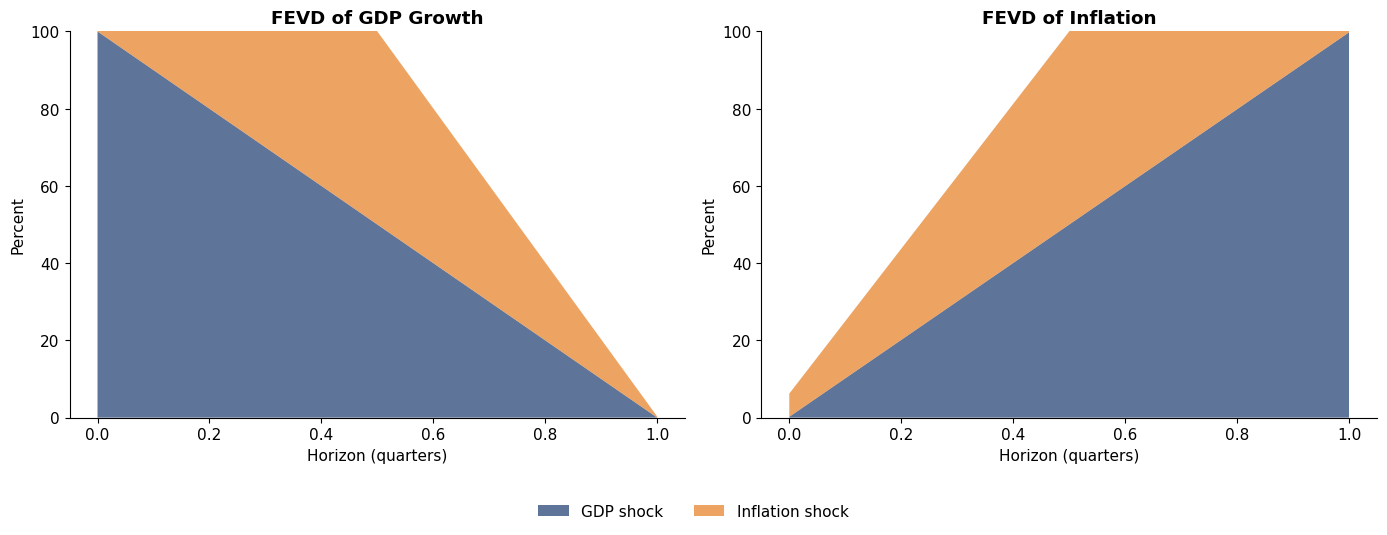


FEVD Table (%)
Horizon      GDP by GDP  GDP by Infl  Infl by GDP Infl by Infl
----------------------------------------------------------------------
1                   0.0          0.3         99.8         94.0
1                   0.0          0.3         99.8         94.0


In [15]:
# Compute FEVD
fevd = results.fevd(20)

# Check the shape of decomp array
print(f"FEVD decomp shape: {fevd.decomp.shape}")
print(f"Periods: {fevd.periods}")

# The decomp array has shape (neqs, neqs, periods+1)
# decomp[i, j, h] = fraction of variance of variable i explained by shock j at horizon h
n_periods = fevd.decomp.shape[2]
n_vars = fevd.decomp.shape[0]
horizons = range(n_periods)

# Plot FEVD
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# FEVD for GDP Growth (variable 0)
gdp_by_gdp = fevd.decomp[0, 0, :] * 100
gdp_by_infl = fevd.decomp[0, 1, :] * 100

axes[0].stackplot(horizons, gdp_by_gdp, gdp_by_infl,
                  labels=['GDP shock', 'Inflation shock'],
                  colors=[COLORS['blue'], COLORS['orange']], alpha=0.7)
axes[0].set_title('FEVD of GDP Growth', fontweight='bold')
axes[0].set_xlabel('Horizon (quarters)')
axes[0].set_ylabel('Percent')
axes[0].set_ylim(0, 100)

# FEVD for Inflation (variable 1)
infl_by_gdp = fevd.decomp[1, 0, :] * 100
infl_by_infl = fevd.decomp[1, 1, :] * 100

axes[1].stackplot(horizons, infl_by_gdp, infl_by_infl,
                  labels=['GDP shock', 'Inflation shock'],
                  colors=[COLORS['blue'], COLORS['orange']], alpha=0.7)
axes[1].set_title('FEVD of Inflation', fontweight='bold')
axes[1].set_xlabel('Horizon (quarters)')
axes[1].set_ylabel('Percent')
axes[1].set_ylim(0, 100)

# Legend outside at bottom
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', ncol=2, bbox_to_anchor=(0.5, -0.08))

plt.tight_layout()
plt.subplots_adjust(bottom=0.15)
plt.show()

# Print table
print("\nFEVD Table (%)")
print("="*70)
print(f"{'Horizon':<10} {'GDP by GDP':>12} {'GDP by Infl':>12} {'Infl by GDP':>12} {'Infl by Infl':>12}")
print("-"*70)
for h in [1, 5, 10, min(20, n_periods-1)]:
    if h < n_periods:
        print(f"{h:<10} {fevd.decomp[0, 0, h]*100:>12.1f} {fevd.decomp[0, 1, h]*100:>12.1f} "
              f"{fevd.decomp[1, 0, h]*100:>12.1f} {fevd.decomp[1, 1, h]*100:>12.1f}")

## 8. VAR Forecasting

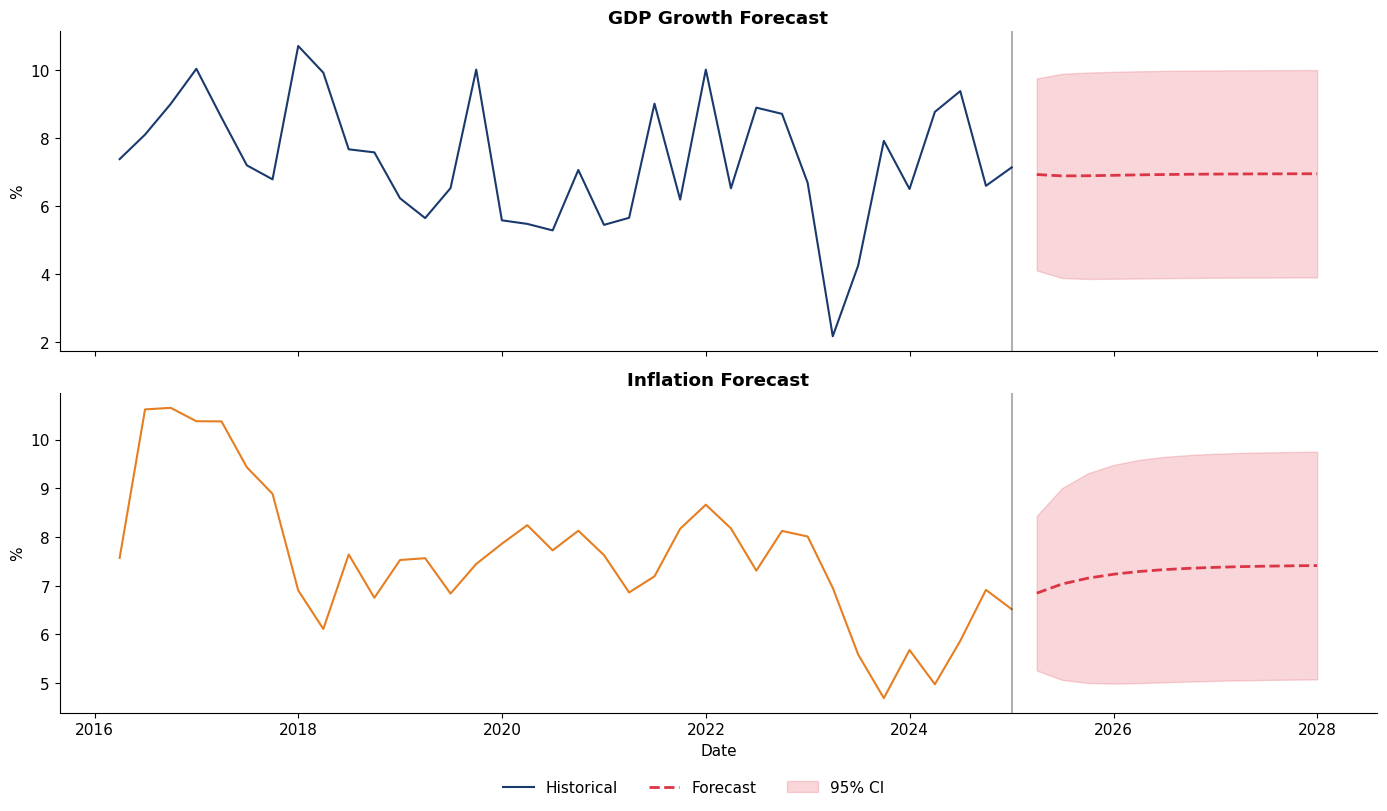


Forecast Summary:
Date                GDP           GDP 95% CI  Inflation          Infl 95% CI
----------------------------------------------------------------------
2025-03-31         6.93 [  4.11,   9.74]       6.85 [  5.26,   8.44]
2025-06-30         6.89 [  3.89,   9.88]       7.04 [  5.07,   9.00]
2025-09-30         6.89 [  3.86,   9.92]       7.16 [  5.00,   9.31]
2025-12-31         6.90 [  3.87,   9.94]       7.24 [  4.99,   9.48]
2026-03-31         6.92 [  3.88,   9.96]       7.29 [  5.00,   9.58]
2026-06-30         6.93 [  3.88,   9.97]       7.33 [  5.02,   9.64]


In [16]:
# Generate forecasts
forecast_steps = 12
lag_order = results.k_ar

forecast = results.forecast(data.values[-lag_order:], steps=forecast_steps)
forecast_interval = results.forecast_interval(data.values[-lag_order:], steps=forecast_steps, alpha=0.05)

# Create forecast dates
forecast_dates = pd.date_range(start=data.index[-1] + pd.DateOffset(months=3), 
                               periods=forecast_steps, freq='QE')

# Plot
fig, axes = plt.subplots(2, 1, figsize=(14, 8), sharex=True)

# GDP Growth
axes[0].plot(data.index[-36:], data['GDP_Growth'].values[-36:], 
             color=COLORS['blue'], linewidth=1.5, label='Historical')
axes[0].plot(forecast_dates, forecast[:, 0], 
             color=COLORS['red'], linewidth=2, linestyle='--', label='Forecast')
axes[0].fill_between(forecast_dates, forecast_interval[1][:, 0], forecast_interval[2][:, 0],
                     color=COLORS['red'], alpha=0.2, label='95% CI')
axes[0].axvline(x=data.index[-1], color='black', linestyle='-', alpha=0.3)
axes[0].set_title('GDP Growth Forecast', fontweight='bold')
axes[0].set_ylabel('%')

# Inflation
axes[1].plot(data.index[-36:], data['Inflation'].values[-36:], 
             color=COLORS['orange'], linewidth=1.5, label='Historical')
axes[1].plot(forecast_dates, forecast[:, 1], 
             color=COLORS['red'], linewidth=2, linestyle='--', label='Forecast')
axes[1].fill_between(forecast_dates, forecast_interval[1][:, 1], forecast_interval[2][:, 1],
                     color=COLORS['red'], alpha=0.2, label='95% CI')
axes[1].axvline(x=data.index[-1], color='black', linestyle='-', alpha=0.3)
axes[1].set_title('Inflation Forecast', fontweight='bold')
axes[1].set_ylabel('%')
axes[1].set_xlabel('Date')

# Legend outside at bottom
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', ncol=3, bbox_to_anchor=(0.5, -0.02))

plt.tight_layout()
plt.subplots_adjust(bottom=0.1)
plt.show()

# Forecast table
print("\nForecast Summary:")
print("="*70)
print(f"{'Date':<12} {'GDP':>10} {'GDP 95% CI':>20} {'Inflation':>10} {'Infl 95% CI':>20}")
print("-"*70)
for i in range(min(6, forecast_steps)):
    print(f"{str(forecast_dates[i].date()):<12} {forecast[i, 0]:>10.2f} "
          f"[{forecast_interval[1][i, 0]:>6.2f}, {forecast_interval[2][i, 0]:>6.2f}] "
          f"{forecast[i, 1]:>10.2f} [{forecast_interval[1][i, 1]:>6.2f}, {forecast_interval[2][i, 1]:>6.2f}]")

## 9. Model Diagnostics

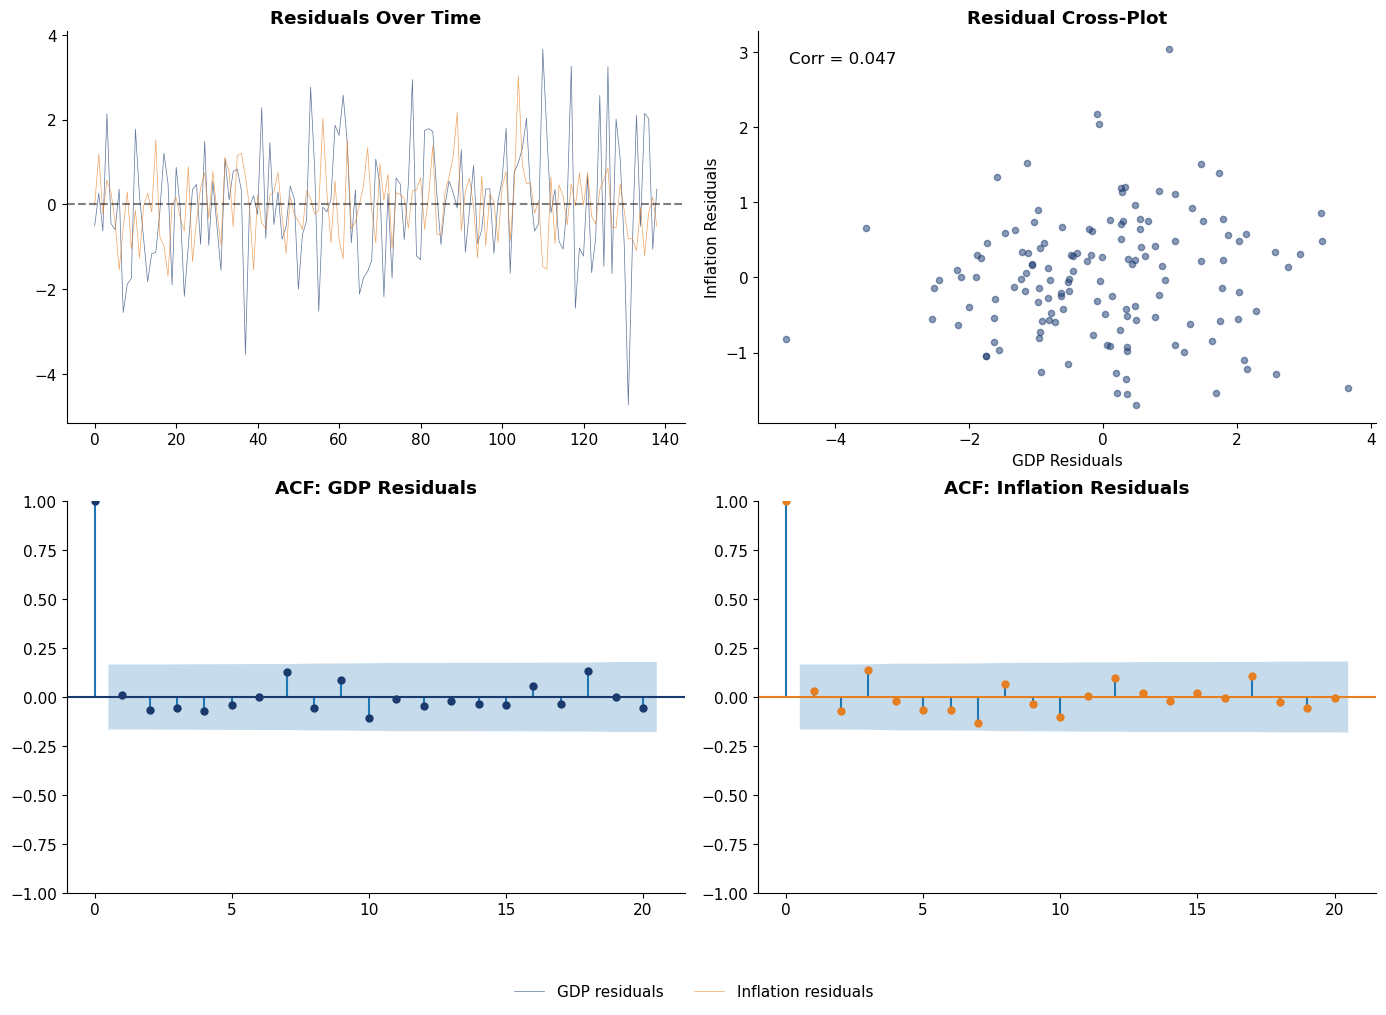

In [17]:
# Residual diagnostics
residuals = results.resid

# Convert to numpy array if it's a DataFrame
if hasattr(residuals, 'values'):
    resid_array = residuals.values
else:
    resid_array = residuals

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Residuals over time
axes[0, 0].plot(resid_array[:, 0], color=COLORS['blue'], alpha=0.7, linewidth=0.5, label='GDP residuals')
axes[0, 0].plot(resid_array[:, 1], color=COLORS['orange'], alpha=0.7, linewidth=0.5, label='Inflation residuals')
axes[0, 0].axhline(y=0, color='black', linestyle='--', alpha=0.5)
axes[0, 0].set_title('Residuals Over Time', fontweight='bold')

# Cross-correlation of residuals
axes[0, 1].scatter(resid_array[:, 0], resid_array[:, 1], alpha=0.5, color=COLORS['blue'], s=20)
axes[0, 1].set_xlabel('GDP Residuals')
axes[0, 1].set_ylabel('Inflation Residuals')
axes[0, 1].set_title('Residual Cross-Plot', fontweight='bold')
corr = np.corrcoef(resid_array[:, 0], resid_array[:, 1])[0, 1]
axes[0, 1].text(0.05, 0.95, f'Corr = {corr:.3f}', transform=axes[0, 1].transAxes, 
                fontsize=12, verticalalignment='top')

# ACF of residuals
plot_acf(resid_array[:, 0], ax=axes[1, 0], lags=20, color=COLORS['blue'], title='')
axes[1, 0].set_title('ACF: GDP Residuals', fontweight='bold')

plot_acf(resid_array[:, 1], ax=axes[1, 1], lags=20, color=COLORS['orange'], title='')
axes[1, 1].set_title('ACF: Inflation Residuals', fontweight='bold')

# Legend outside at bottom for first subplot
handles, labels = axes[0, 0].get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', ncol=2, bbox_to_anchor=(0.5, -0.02))

plt.tight_layout()
plt.subplots_adjust(bottom=0.1)
plt.show()

In [18]:
# Portmanteau test
print("Portmanteau Test for Residual Autocorrelation:")
print(results.test_whiteness(nlags=12).summary())

Portmanteau Test for Residual Autocorrelation:
Portmanteau-test for residual autocorrelation. H_0: residual autocorrelation up to lag 12 is zero. Conclusion: fail to reject H_0 at 5% significance level.
Test statistic Critical value p-value df
----------------------------------------
         39.76          60.48   0.654 44
----------------------------------------


## 10. Cointegration and VECM

When variables are **I(1)** (non-stationary) but share a long-run equilibrium, they are **cointegrated**.

### Vector Error Correction Model (VECM)
$$\Delta \mathbf{Y}_t = \boldsymbol{\Pi} \mathbf{Y}_{t-1} + \sum_{i=1}^{p-1} \boldsymbol{\Gamma}_i \Delta \mathbf{Y}_{t-i} + \boldsymbol{\varepsilon}_t$$

where $\boldsymbol{\Pi} = \boldsymbol{\alpha} \boldsymbol{\beta}'$ contains:
- $\boldsymbol{\beta}$: cointegrating vectors (long-run relationships)
- $\boldsymbol{\alpha}$: adjustment speeds (error correction)

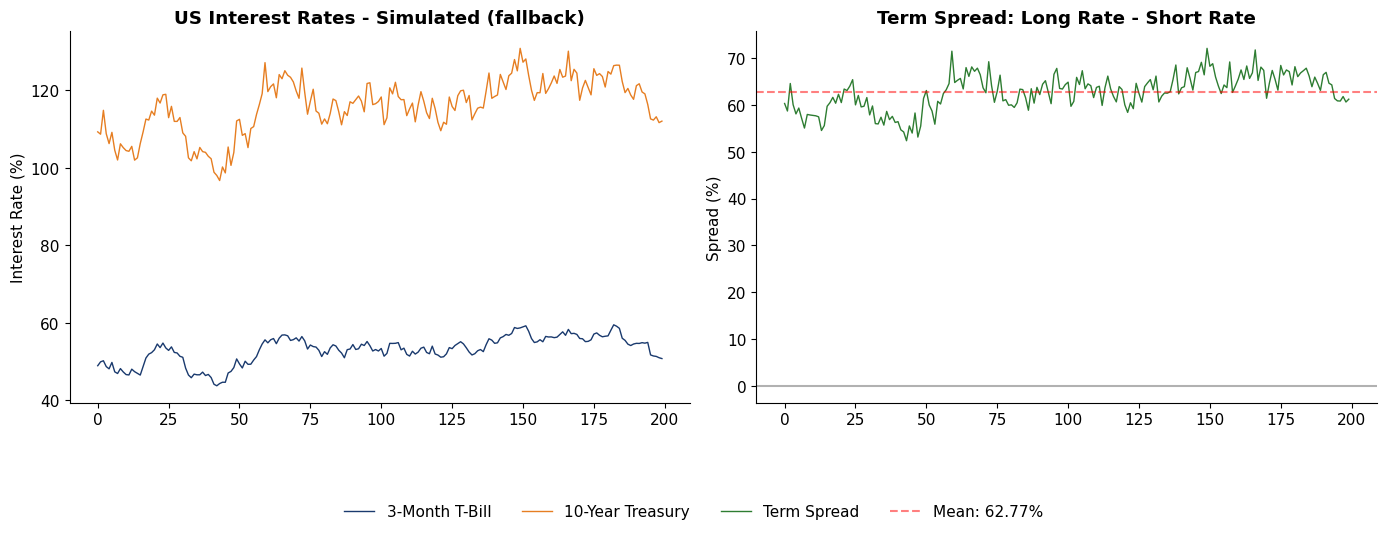

In [19]:
# Cointegration Example: US Interest Rates
# Short-term (3-month T-bill) and Long-term (10-year Treasury) yields

if HAS_PDR:
    try:
        # Fetch Treasury rates from FRED
        short_rate = web.DataReader('TB3MS', 'fred', '1990-01-01', '2024-12-31')
        long_rate = web.DataReader('GS10', 'fred', '1990-01-01', '2024-12-31')
        
        coint_data = pd.DataFrame({
            'ShortRate': short_rate['TB3MS'],
            'LongRate': long_rate['GS10']
        }).dropna()
        
        print(f"✓ Real Interest Rate Data: {len(coint_data)} monthly observations")
        COINT_SOURCE = "FRED Treasury Rates"
        
    except Exception as e:
        print(f"Could not fetch rate data: {e}")
        HAS_PDR = False

if not HAS_PDR:
    # Fallback: Simulated cointegrated data
    np.random.seed(123)
    n = 200
    
    x = np.cumsum(np.random.randn(n)) + 50
    y = 2 * x + np.random.randn(n) * 2 + 10
    
    coint_data = pd.DataFrame({'ShortRate': x, 'LongRate': y})
    COINT_SOURCE = "Simulated (fallback)"

# Plot
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].plot(coint_data.index, coint_data['ShortRate'], color=COLORS['blue'], 
             label='3-Month T-Bill', linewidth=1)
axes[0].plot(coint_data.index, coint_data['LongRate'], color=COLORS['orange'], 
             label='10-Year Treasury', linewidth=1)
axes[0].set_title(f'US Interest Rates - {COINT_SOURCE}', fontweight='bold')
axes[0].set_ylabel('Interest Rate (%)')

# Spread (term spread)
spread = coint_data['LongRate'] - coint_data['ShortRate']
axes[1].plot(spread.index, spread, color=COLORS['green'], linewidth=1, label='Term Spread')
axes[1].axhline(y=spread.mean(), color='red', linestyle='--', alpha=0.5, 
                label=f'Mean: {spread.mean():.2f}%')
axes[1].axhline(y=0, color='black', linestyle='-', alpha=0.3)
axes[1].set_title('Term Spread: Long Rate - Short Rate', fontweight='bold')
axes[1].set_ylabel('Spread (%)')

# Legends outside at bottom
handles1, labels1 = axes[0].get_legend_handles_labels()
handles2, labels2 = axes[1].get_legend_handles_labels()
fig.legend(handles1 + handles2, labels1 + labels2, loc='lower center', ncol=4, bbox_to_anchor=(0.5, -0.08))

plt.tight_layout()
plt.subplots_adjust(bottom=0.18)
plt.show()

In [20]:
# Unit root tests for cointegration analysis
print("Unit Root Tests (ADF):")
print("="*60)
for col in ['ShortRate', 'LongRate']:
    result = adfuller(coint_data[col].dropna())
    status = "Stationary" if result[1] < 0.05 else "Non-stationary (I(1))"
    print(f"{col:>12}: ADF = {result[0]:>7.3f}, p-value = {result[1]:.4f} → {status}")

result = adfuller(spread.dropna())
status = "Stationary" if result[1] < 0.05 else "Non-stationary"
print(f"{'Spread':>12}: ADF = {result[0]:>7.3f}, p-value = {result[1]:.4f} → {status}")

print("\nIf rates are I(1) but spread is I(0), the rates are cointegrated!")

Unit Root Tests (ADF):
   ShortRate: ADF =  -2.254, p-value = 0.1874 → Non-stationary (I(1))
    LongRate: ADF =  -2.715, p-value = 0.0714 → Non-stationary (I(1))
      Spread: ADF =  -2.520, p-value = 0.1108 → Non-stationary

If rates are I(1) but spread is I(0), the rates are cointegrated!


In [21]:
# Johansen cointegration test
print("\nJohansen Cointegration Test:")
print("="*60)

johansen_result = coint_johansen(coint_data, det_order=0, k_ar_diff=1)

print("\nTrace Statistics:")
print(f"{'Rank':>6} {'Trace Stat':>12} {'Crit 95%':>12} {'Crit 99%':>12}")
print("-"*50)
for i in range(2):
    sig = " **" if johansen_result.lr1[i] > johansen_result.cvt[i, 1] else ""
    print(f"{i:>6} {johansen_result.lr1[i]:>12.2f} {johansen_result.cvt[i, 1]:>12.2f} "
          f"{johansen_result.cvt[i, 2]:>12.2f}{sig}")

print("\nConclusion: Reject rank=0, cannot reject rank=1")
print("→ There is 1 cointegrating relationship")


Johansen Cointegration Test:

Trace Statistics:
  Rank   Trace Stat     Crit 95%     Crit 99%
--------------------------------------------------
     0        95.70        15.49        19.93 **
     1         5.17         3.84         6.63 **

Conclusion: Reject rank=0, cannot reject rank=1
→ There is 1 cointegrating relationship


In [22]:
# Fit VECM
vecm = VECM(coint_data, k_ar_diff=1, coint_rank=1, deterministic='ci')
vecm_results = vecm.fit()

print("\nVECM Estimation Results:")
print("="*60)
print(vecm_results.summary())


VECM Estimation Results:
Det. terms outside the coint. relation & lagged endog. parameters for equation ShortRate
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
L1.ShortRate     0.0002      0.104      0.002      0.999      -0.205       0.205
L1.LongRate      0.0181      0.040      0.449      0.653      -0.061       0.097
Det. terms outside the coint. relation & lagged endog. parameters for equation LongRate
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
L1.ShortRate    -0.0520      0.278     -0.187      0.852      -0.597       0.493
L1.LongRate      0.1010      0.107      0.942      0.346      -0.109       0.311
             Loading coefficients (alpha) for equation ShortRate              
                 coef    std err          z      P>|z|      [0.025    

## 11. Cross-Correlation Function

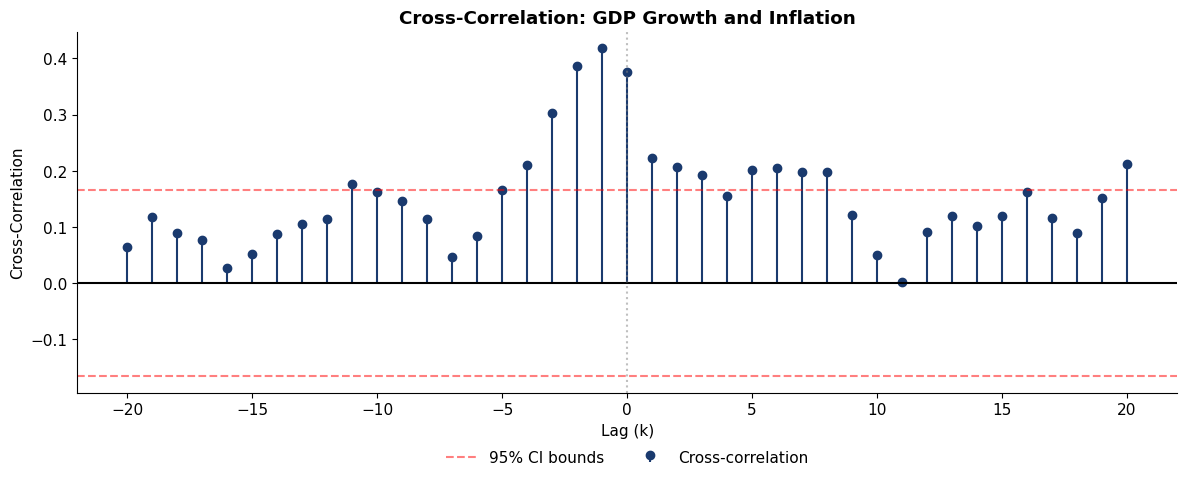

In [23]:
# Cross-correlation between GDP and Inflation
from scipy import signal

# Compute CCF
x = data['GDP_Growth'].values
y = data['Inflation'].values

# Normalize
x_norm = (x - np.mean(x)) / np.std(x)
y_norm = (y - np.mean(y)) / np.std(y)

# Cross-correlation
ccf_values = np.correlate(x_norm, y_norm, mode='full') / len(x)
lags = np.arange(-len(x)+1, len(x))

# Plot
fig, ax = plt.subplots(figsize=(12, 5))

# Only show lags -20 to 20
mask = (lags >= -20) & (lags <= 20)
ax.stem(lags[mask], ccf_values[mask], linefmt=COLORS['blue'], markerfmt='o', basefmt=' ', label='Cross-correlation')
ax.axhline(y=0, color='black', linestyle='-')
ax.axhline(y=1.96/np.sqrt(len(x)), color='red', linestyle='--', alpha=0.5, label='95% CI bounds')
ax.axhline(y=-1.96/np.sqrt(len(x)), color='red', linestyle='--', alpha=0.5)
ax.axvline(x=0, color='gray', linestyle=':', alpha=0.5)

ax.set_xlabel('Lag (k)')
ax.set_ylabel('Cross-Correlation')
ax.set_title('Cross-Correlation: GDP Growth and Inflation', fontweight='bold')

# Legend outside at bottom
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.12), ncol=2)

plt.tight_layout()
plt.subplots_adjust(bottom=0.2)
plt.show()

In [24]:
print("Interpretation:")
print("- Positive lag k: GDP leads Inflation by k periods")
print("- Negative lag k: Inflation leads GDP by k periods")
print("- Peak correlation shows dominant lead-lag relationship")

Interpretation:
- Positive lag k: GDP leads Inflation by k periods
- Negative lag k: Inflation leads GDP by k periods
- Peak correlation shows dominant lead-lag relationship


## Summary

### Key Takeaways

1. **VAR models** capture dynamic interdependencies between multiple time series
   - Each variable depends on its own lags AND lags of other variables
   - OLS estimation is efficient with identical regressors

2. **Stability** requires all eigenvalues inside the unit circle
   - Ensures stationarity and convergent impulse responses

3. **Granger causality** tests predictive content, not true causation
   - Useful for understanding lead-lag relationships
   - Sensitive to lag selection and omitted variables

4. **Impulse Response Functions** trace shock propagation
   - Requires identification (Cholesky, structural restrictions)
   - Shows dynamic multipliers over time

5. **FEVD** decomposes forecast variance by shock source
   - Shows relative importance of different shocks

6. **Cointegration** exists when I(1) variables share long-run equilibrium
   - Use VECM to model both short-run and long-run dynamics
   - Johansen test for testing cointegration rank

### Practical Workflow
1. Check stationarity (unit root tests)
2. Select lag order (information criteria)
3. Estimate VAR or VECM
4. Diagnostic checks (residual autocorrelation)
5. Granger causality tests
6. IRF and FEVD analysis
7. Forecasting